<a href="https://colab.research.google.com/github/UranMai/Binding_affinity/blob/master/MPNN_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing PyTorch Geometric and RDKit 


In [0]:
!pip install --verbose --no-cache-dir torch-scatter 
!pip install --verbose --no-cache-dir torch-sparse 
!pip install --verbose --no-cache-dir torch-cluster 
!pip install --verbose --no-cache-dir torch-spline-conv
!pip install torch-geometric

In [0]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 torch-spline-conv==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html


In [5]:
import torch
print(torch.__version__)
torch.cuda.is_available()


from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops

from torch_geometric.utils import add_self_loops
from torch_geometric.data import Data

import numpy as np
import pandas as pd
import pickle
import csv
import os
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

1.4.0


In [0]:
#Install rdkit library for molecules
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

# Data preparation

In [0]:
from __future__ import division
from __future__ import unicode_literals
import multiprocessing
import logging

# following code was borrowed from deepchem
# https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/feat/graph_features.py
 
 
def one_of_k_encoding(x, allowable_set):
  if x not in allowable_set:
    raise Exception("input {0} not in allowable set{1}:".format(
        x, allowable_set))
  return list(map(lambda s: x == s, allowable_set))
 
 
def one_of_k_encoding_unk(x, allowable_set):
  """Maps inputs not in the allowable set to the last element."""
  if x not in allowable_set:
    x = allowable_set[-1]
  return list(map(lambda s: x == s, allowable_set))
 
 
def get_intervals(l):
  """For list of lists, gets the cumulative products of the lengths"""
  intervals = len(l) * [0]
  # Initalize with 1
  intervals[0] = 1
  for k in range(1, len(l)):
    intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
 
  return intervals
 
 
def safe_index(l, e):
  """Gets the index of e in l, providing an index of len(l) if not found"""
  try:
    return l.index(e) # return the index of element in list
  except:
    return len(l)
 
 
possible_atom_list = [
    'C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Mg', 'Na', 'Br', 'Fe', 'Ca', 'Cu',
    'Mc', 'Pd', 'Pb', 'K', 'I', 'Al', 'Ni', 'Mn'
]
possible_numH_list = [0, 1, 2, 3, 4]
possible_valence_list = [0, 1, 2, 3, 4, 5, 6]
possible_formal_charge_list = [-3, -2, -1, 0, 1, 2, 3]
possible_hybridization_list = [
    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_number_radical_e_list = [0, 1, 2]
possible_chirality_list = ['R', 'S']
 
reference_lists = [
    possible_atom_list, possible_numH_list, possible_valence_list,
    possible_formal_charge_list, possible_number_radical_e_list,
    possible_hybridization_list, possible_chirality_list]
 
intervals = get_intervals(reference_lists)
 
 
def get_feature_list(atom):
  features = 6 * [0]
  features[0] = safe_index(possible_atom_list, atom.GetSymbol())
  features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
  features[2] = safe_index(possible_valence_list, atom.GetImplicitValence())
  features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())
  features[4] = safe_index(possible_number_radical_e_list, atom.GetNumRadicalElectrons())
  features[5] = safe_index(possible_hybridization_list, atom.GetHybridization())
  #features[6] = safe_index(possible_chirality_list, atom.)
  return features
 
 
def features_to_id(features, intervals):
  """Convert list of features into index using spacings provided in intervals"""
  id = 0
  for k in range(len(intervals)):
    id += features[k] * intervals[k]
 
  # Allow 0 index to correspond to null molecule 1
  id = id + 1
  return id
 
 
def id_to_features(id, intervals):
  features = 6 * [0]
 
  # Correct for null
  id -= 1
 
  for k in range(0, 6 - 1):
    # print(6-k-1, id)
    features[6 - k - 1] = id // intervals[6 - k - 1]
    id -= features[6 - k - 1] * intervals[6 - k - 1]
  # Correct for last one
  features[0] = id
  return features
 
 
def atom_to_id(atom):
  """Return a unique id corresponding to the atom type"""
  features = get_feature_list(atom)
  return features_to_id(features, intervals)
 
 
def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
  if bool_id_feat:
    return np.array([atom_to_id(atom)])
  else:
    from rdkit import Chem
    results = one_of_k_encoding_unk(
      atom.GetSymbol(),
      [
        'C','N', 'O','S','F','Si','P','Cl','Br','Mg', 'Na','Ca','Fe','As', 'Al','I','B','V', 'K','Tl','Yb','Sb',
        'Sn','Ag', 'Pd','Co', 'Se', 'Ti','Zn','H',  'Li', 'Ge', 'Cu', 'Au','Ni','Cd','In','Mn', 'Zr','Cr','Pt','Hg', 'Pb', 'Unknown'
      ]) + one_of_k_encoding(atom.GetDegree(),
                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + \
              one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
              ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
      #results = results + list(atom.GetTotalNumHs())
      results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),[0, 1, 2, 3, 4])
    if use_chirality:
      try:
        results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
      except:
        results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]
 
    return np.array(results)
 
def bond_features(bond, use_chirality=False):
  from rdkit import Chem
  bt = bond.GetBondType()
  bond_feats = [
      bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
      bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
      bond.GetIsConjugated(),
      bond.IsInRing()
  ]
  if use_chirality:
    bond_feats = bond_feats + one_of_k_encoding_unk(
        str(bond.GetStereo()),
        ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
  return np.array(bond_feats)
 

def get_bond_pair(mol):
  bonds = mol.GetBonds()
  res = [[],[]]
  for bond in bonds:
    res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
    res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
  return res
 
def mol2vec(mol):
  atoms = mol.GetAtoms()
  bonds = mol.GetBonds()
  node_f= [atom_features(atom) for atom in atoms] #array for each atom in molecule
  edge_index = get_bond_pair(mol)
  edge_attr = [bond_features(bond, use_chirality=False) for bond in bonds]
  for bond in bonds: 
    edge_attr.append(bond_features(bond))
  data = Data(x=torch.tensor(node_f, dtype=torch.float),
              edge_index=torch.tensor(edge_index, dtype=torch.long),
              edge_attr=torch.tensor(edge_attr,dtype=torch.float)
              )
  #y=torch.tensor()
  return data

In [0]:
train = pd.read_csv('train_data.csv', index_col=0)
valid = pd.read_csv('valid_data.csv', index_col=0)
test = pd.read_csv('test_data.csv', index_col=0)

train_data = train.drop(train[train.Score>0].index)
valid_data = valid.drop(valid[valid.Score>0].index)
test_data = test.drop(test[test.Score>0].index)

In [0]:
train_X = [mol2vec(Chem.MolFromSmiles(m)) for m in train_data.smi]
for i, data in enumerate(train_X):
    y = train_data.Score.values[i]
    data.y = torch.tensor([y], dtype=torch.float)

valid_X = [mol2vec(Chem.MolFromSmiles(m)) for m in valid_data.smi]
for i, data in enumerate(valid_X):
    y = valid_data.Score.values[i]
    data.y = torch.tensor([y], dtype=torch.float)

test_X = [mol2vec(Chem.MolFromSmiles(m)) for m in test_data.smi]
for i, data in enumerate(test_X):
    y = test_data.Score.values[i]
    data.y = torch.tensor([y], dtype=torch.float)

train_loader = DataLoader(train_X, batch_size=64, shuffle=False)
valid_loader = DataLoader(valid_X, batch_size=64, shuffle=False)
test_loader = DataLoader(test_X, batch_size=64, shuffle=False)

# NN Model

In [0]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU

import torch_geometric.transforms as T
from torch_geometric.nn import NNConv, Set2Set #NNConv (implemented MPNN); Set2Set 
from torch_geometric.data import DataLoader
from torch_geometric.utils import remove_self_loops

#n_features = 75
#dim = 64

class Net(torch.nn.Module):
  def __init__(self, node_dim=75, dim=64):
    super(Net, self).__init__()
    #super(Net, self).__init__(self, input_dimensions,...)

    self.lin0 = torch.nn.Linear(node_dim, dim) #[n-node_dim]
    nn = Sequential(Linear(6, 128),  #[edge_input_dimensions]
                    ReLU(), 
                    Linear(128, dim*dim)) #NN for edge features
    #self.conv = NNConv(dim, dim, nn, aggr = 'add') #agger='add'/n_features or dim size?? [64,64]
    self.conv = NNConv(in_channels=dim, out_channels=dim, nn=nn, aggr='add')
    self.gru = GRU(dim, dim)

    self.set2set = Set2Set(dim, processing_steps=3, num_layers=1) #return data twice dimensionality of input data [64,128]
    self.lin1 = torch.nn.Linear(2*dim, dim)
    self.lin2 = torch.nn.Linear(dim, 1)
    #self.lin2 = torch.nn.Linear(dim, 2) #for 2 labels classifications

  def forward(self, data): #one of the batches of data

    out = F.relu(self.lin0(data.x)) #[2430,64]
    h = out.unsqueeze(0) #[1,2430,64]

    for i in range(3):
            m = F.relu(self.conv(out, data.edge_index, data.edge_attr)) #[2430,64]
            out, h = self.gru(m.unsqueeze(0), h)
            #out[1,2430,64] and h[1,2430,64]
            out = out.squeeze(0) #[2430,64]

    out = self.set2set(out, data.batch) #[101,128]
    out = F.relu(self.lin1(out)) #[101,64]
    out = self.lin2(out)#[101,1]

    #2dimensional classification
    #out1 = F.log_softmax(out, dim=1) #for classification 0 or 1
    return out.view(-1) #reshape[101]
    #return out1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3,
                                                       min_lr=0.00001)

In [16]:
model.state_dict

<bound method Module.state_dict of Net(
  (lin0): Linear(in_features=75, out_features=64, bias=True)
  (conv): NNConv(64, 64)
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)>

In [0]:
def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = F.mse_loss(model(data), data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def test(loader):
    model.eval()
    error = 0
    
    for data in loader:
        data = data.to(device)
        pred = model(data)
        error += F.l1_loss(pred, data.y).item()
    return error / len(loader.dataset)

def target(loader):
  model.eval()
  targets = dict()
  for data in loader:
      data = data.to(device)
      y_pred = model(data)
      for i in range(len(data.y)):
          targets[data.y[i].item()] = y_pred[i].tolist()
  return targets

In [23]:

for epoch in range(1, 50):
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train(epoch)
    val_error = test(valid_loader)
    scheduler.step(val_error)
    test_error = test(test_loader)
    

    print('Epoch: {:03d}, LR: {:7f}, Loss: {:.7f}, Validation MAE: {:.7f}, '
          'Test MAE: {:.7f}'.format(epoch, lr, loss, val_error, test_error))

Epoch: 001, LR: 0.001000, Loss: 38.5556554, Validation MAE: 0.0785755, Test MAE: 0.0786766
Epoch: 002, LR: 0.001000, Loss: 38.1768868, Validation MAE: 0.0766935, Test MAE: 0.0762547
Epoch: 003, LR: 0.001000, Loss: 33.9818320, Validation MAE: 0.0710252, Test MAE: 0.0709330
Epoch: 004, LR: 0.001000, Loss: 30.9873640, Validation MAE: 0.0712743, Test MAE: 0.0702325
Epoch: 005, LR: 0.001000, Loss: 30.6431082, Validation MAE: 0.0700573, Test MAE: 0.0684754
Epoch: 006, LR: 0.001000, Loss: 29.9651621, Validation MAE: 0.0703559, Test MAE: 0.0694870
Epoch: 007, LR: 0.001000, Loss: 29.8974156, Validation MAE: 0.0697751, Test MAE: 0.0687942
Epoch: 008, LR: 0.001000, Loss: 29.6243362, Validation MAE: 0.0699147, Test MAE: 0.0690220
Epoch: 009, LR: 0.001000, Loss: 29.4682259, Validation MAE: 0.0685920, Test MAE: 0.0677712
Epoch: 010, LR: 0.001000, Loss: 29.1240075, Validation MAE: 0.0686913, Test MAE: 0.0682060
Epoch: 011, LR: 0.001000, Loss: 28.9688830, Validation MAE: 0.0684111, Test MAE: 0.0676825

In [0]:
targets = target(test_loader) # dictionary of real and predicted values

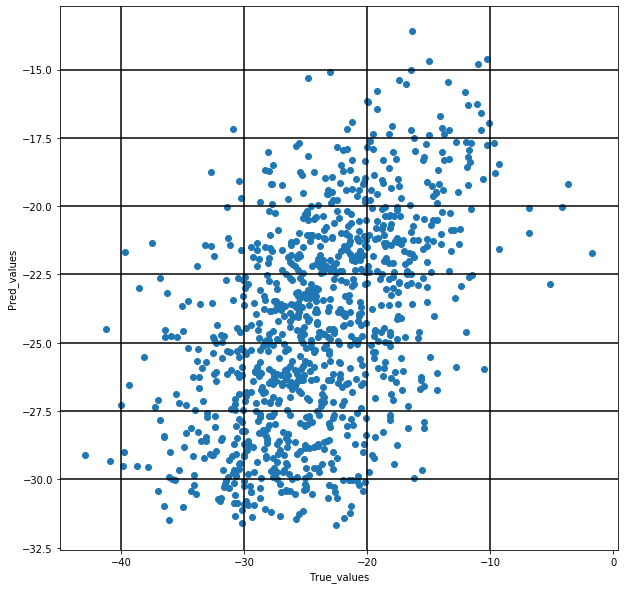

In [47]:
import matplotlib.pylab as plt
plt.figure(figsize=(10,10))
lists = sorted(targets.items())

x, y = zip(*lists) 

plt.scatter(x, y)
x_coord = [-40,-30,-20,-10]
y_coord = [-30, -27.5, -25, -22.5, -20, -17.5, -15]
for x in x_coord:
  plt.axvline(x=x, color='k')
for y in y_coord:
  plt.axhline(y=y, color='k')
plt.xlabel('True_values')
plt.ylabel('Pred_values')
plt.show()